In [16]:
import scanpy as sc
import pandas as pd
import numpy as np
import os, torch
import h5py
from tqdm import tqdm

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.6 anndata==0.9.2 umap==0.5.4 numpy==1.24.4 scipy==1.10.1 pandas==1.5.0 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


#### 1107 分析采用PLIP进行tumor filter后的特征可视化

In [18]:
feats_path_dir = "/home/cyyan/Projects/HER2proj/results/HEROHE_test_2FeatsCCL_40x_tumor/h5_files"

featpath_list = os.listdir(feats_path_dir)

# set_features = np.empty(shape=(0, 2048))
# set_coords = np.empty(shape=(0, 2))
test_set_features = []
test_set_coords = []
test_tissue_type = []
test_slides_id = []
test_set_plip_feats = []

num_perslide = 100
flag = "all"

for name in tqdm(featpath_list):
    full_path = os.path.join(feats_path_dir, name)
    # print(full_path)
        
    # features = torch.load(full_path)
    with h5py.File(full_path,'r') as hdf5_file:
        features = hdf5_file['features'][:]
        coords = hdf5_file['coords'][:]
        tissue_type = hdf5_file['plip_tissue_idx'][:]
        plip_feats = hdf5_file['plip_feats'][:]

    if flag == "mean":
        test_set_features.append(np.mean(features, axis=0)[None, ])
        test_set_coords.append(np.mean(coords, axis=0)[None, ])
        test_slides_id.append(name.split('.')[0])

    elif flag == "random":
        idx = np.random.choice(len(features), num_perslide) if num_perslide < len(features) else range(len(features))

        test_set_features.append(features[idx, :])
        test_set_coords.append(coords[idx, :])
        test_slides_id.extend([name.split('.')[0]]*len(idx))
    elif flag == "all":
        test_set_features.append(features)
        test_set_coords.append(coords)
        test_tissue_type.append(tissue_type)
        test_set_plip_feats.append(plip_feats)
        test_slides_id.extend([name.split('.')[0]]*len(tissue_type))

test_set_features = np.concatenate(test_set_features, axis=0)
test_set_coords = np.concatenate(test_set_coords, axis=0)
test_tissue_type = np.concatenate(test_tissue_type, axis=0)
test_set_plip_feats = np.concatenate(test_set_plip_feats, axis=0)

print("total features, shape: {}".format(test_set_features.shape))
print("total plip features, shape: {}".format(test_set_plip_feats.shape))

print("total coords, shape: {}".format(test_set_coords.shape))
print("total slide_ids, shape: {}".format(len(test_slides_id)))

100%|██████████| 32/32 [01:04<00:00,  2.03s/it]


total features, shape: (378023, 2048)
total plip features, shape: (378023, 512)
total coords, shape: (378023, 2)
total slide_ids, shape: 378023


### 1107 下述代码使用retCCL提取的特征进行cluster，同时对比PLIP的zero shot分类结果

       tissue type tumor flag
0                7      False
1                7      False
2                4       True
3                7      False
4                7      False
...            ...        ...
378018           7      False
378019           1      False
378020           7      False
378021           7      False
378022           7      False

[378023 rows x 2 columns]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:25)
running Leiden clustering
    finished: found 35 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:14:02)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:15)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP 

/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


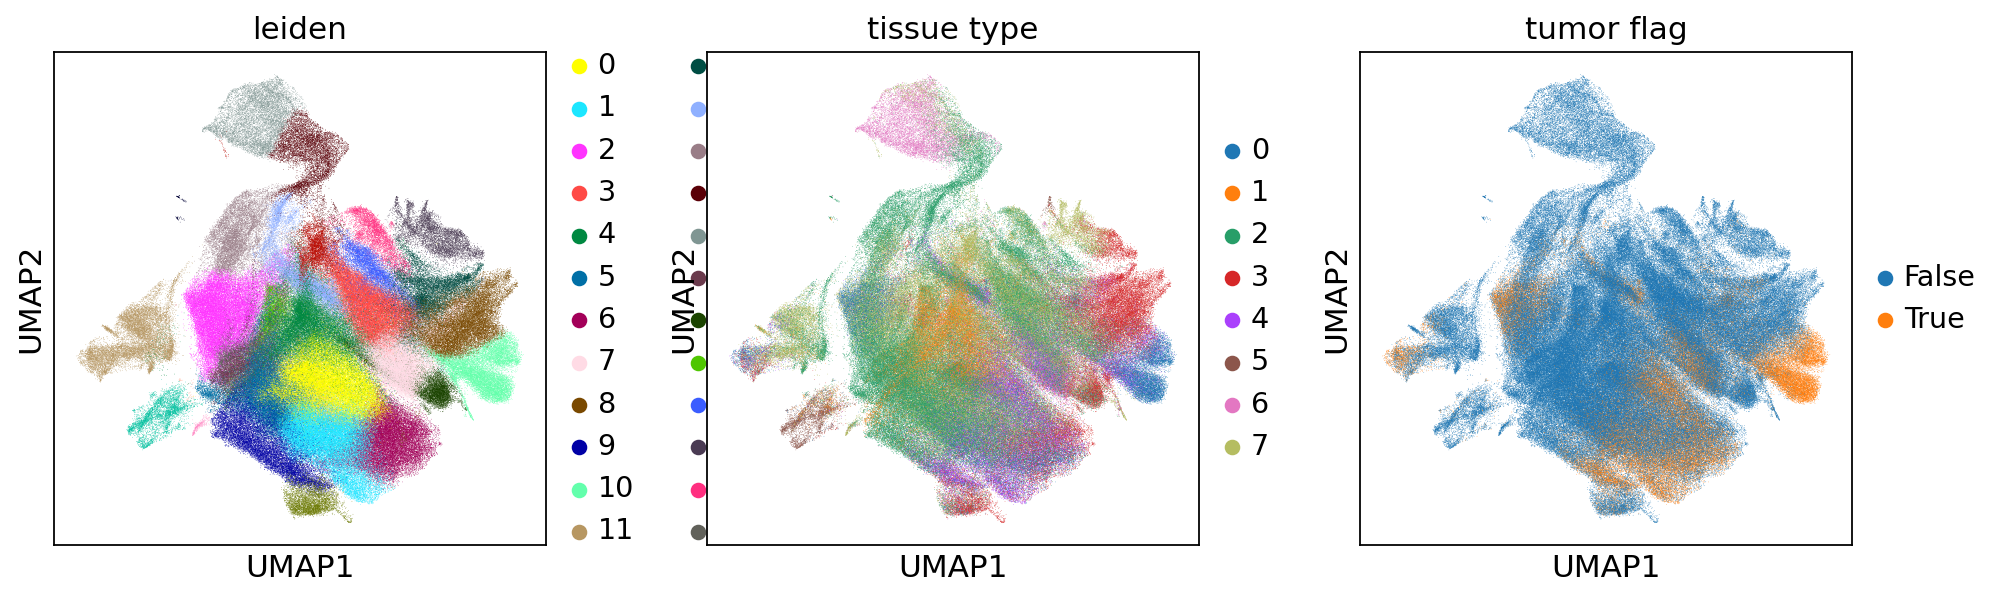

In [41]:
adata = sc.AnnData(X=test_set_features)
# print(pd.Series(set_name, name="set_name"))
# adata.obs['w_coord', 'h_coord'] = pd.DataFrame(set_coords, columns=["w_coord", "h_coord"])
# adata.obs['slides_id'] = pd.DataFrame(slides_id, columns=['slides_id'])
adata.obs = pd.DataFrame(test_tissue_type.astype(str), columns=["tissue type"])

reserve_flag = [each in [0, 4] for each in test_tissue_type] 
adata.obs['tumor flag'] = pd.DataFrame(np.array(reserve_flag).astype(str), columns=["tumor flag"])

# adata.obs = pd.DataFrame(slides_id, columns=['slides_id'])
print(adata.obs)


sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep='X')
sc.tl.leiden(adata)

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'tissue type', 'tumor flag'])

### 1107 下述代码对PLIPzero shot得到的tumor类和gland进行cluster，使用的特征是retCCL特征

      tissue type
0               4
1               0
2               0
3               0
4               4
...           ...
63560           4
63561           4
63562           4
63563           4
63564           4

[63565 rows x 1 columns]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:49)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


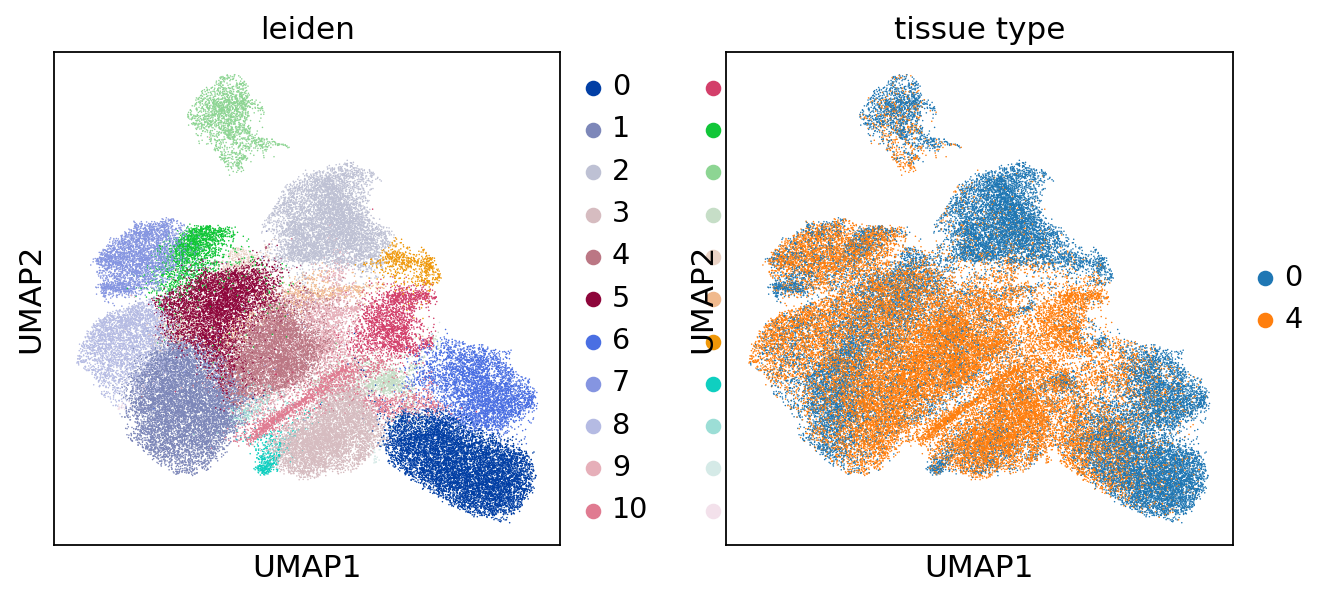

In [37]:
reserve_flag = [each in [0, 4] for each in test_tissue_type] 

adata = sc.AnnData(X=test_set_features[reserve_flag, :])
# print(pd.Series(set_name, name="set_name"))
# adata.obs['w_coord', 'h_coord'] = pd.DataFrame(set_coords, columns=["w_coord", "h_coord"])
# adata.obs['slides_id'] = pd.DataFrame(slides_id, columns=['slides_id'])
adata.obs = pd.DataFrame(test_tissue_type[reserve_flag].astype(str), columns=["tissue type"])
# adata.obs = pd.DataFrame(slides_id, columns=['slides_id'])
print(adata.obs)


sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep='X')
sc.tl.leiden(adata)

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'tissue type'])

### 1107 下述代码直接对PLIP得到的特征进行cluster，同时对比zero shot分类结果

       tissue type tumor flag
0                7      False
1                7      False
2                4       True
3                7      False
4                7      False
...            ...        ...
378018           7      False
378019           1      False
378020           7      False
378021           7      False
378022           7      False

[378023 rows x 2 columns]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)
running Leiden clustering
    finished: found 29 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:11:20)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:12)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP 

/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


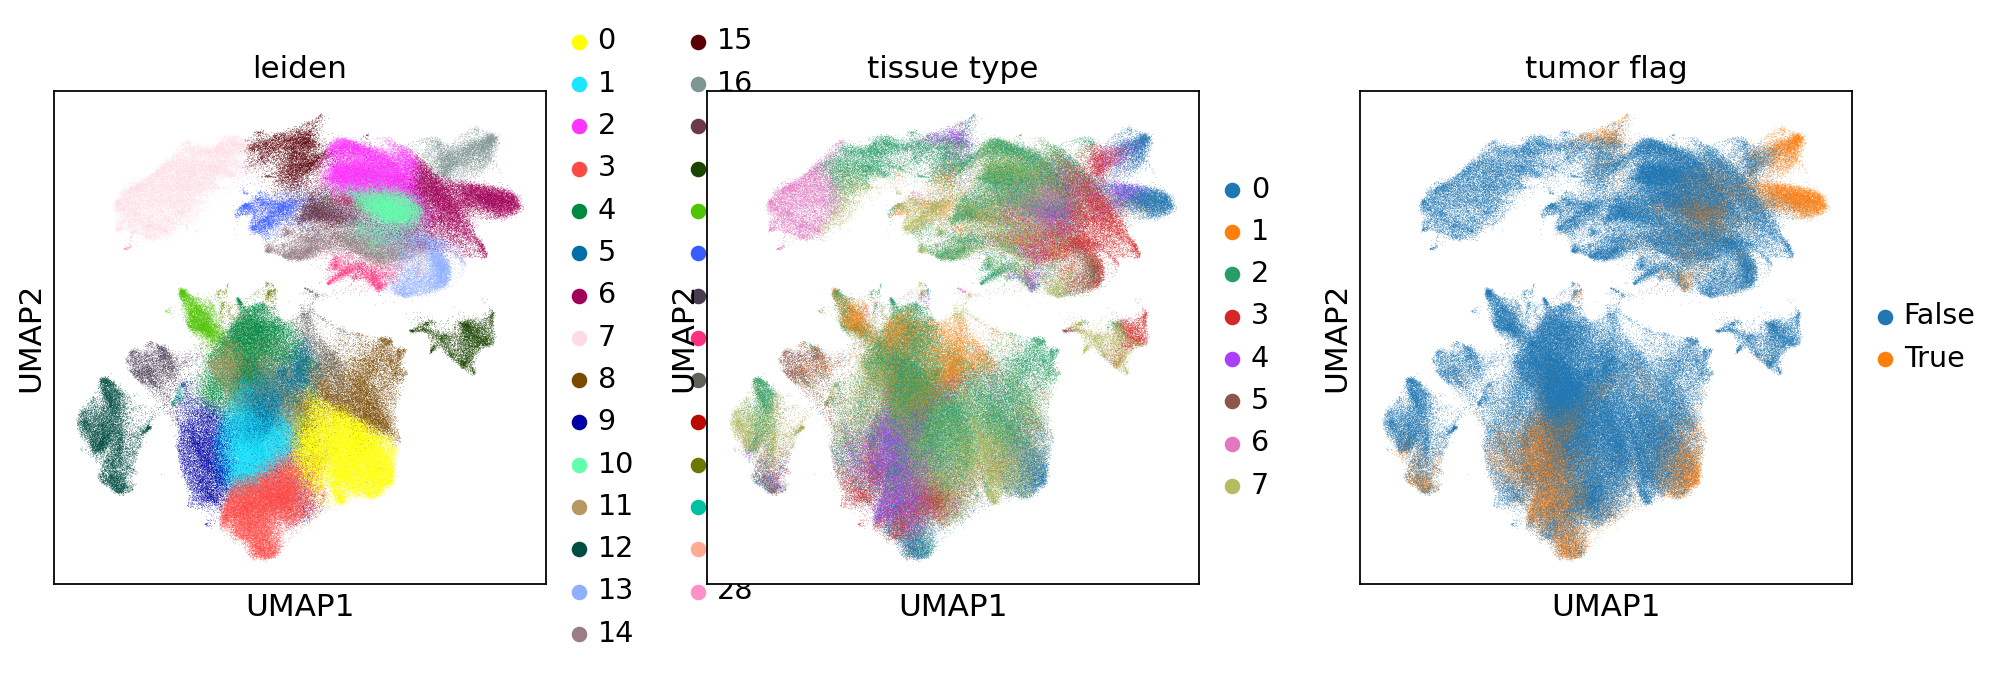

In [44]:
adata = sc.AnnData(X=test_set_plip_feats)
# print(pd.Series(set_name, name="set_name"))
# adata.obs['w_coord', 'h_coord'] = pd.DataFrame(set_coords, columns=["w_coord", "h_coord"])
# adata.obs['slides_id'] = pd.DataFrame(slides_id, columns=['slides_id'])
adata.obs = pd.DataFrame(test_tissue_type.astype(str), columns=["tissue type"])

reserve_flag = [each in [0, 4] for each in test_tissue_type] 
adata.obs['tumor flag'] = pd.DataFrame(np.array(reserve_flag).astype(str), columns=["tumor flag"])

# adata.obs = pd.DataFrame(slides_id, columns=['slides_id'])
print(adata.obs)


sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep='X')
sc.tl.leiden(adata)

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'tissue type', 'tumor flag'])

### 1107 下述代码对PLIPzero shot得到的tumor类和gland进行cluster，使用的特征也是PLIP特征

      tissue type
0               4
1               0
2               0
3               0
4               4
...           ...
63560           4
63561           4
63562           4
63563           4
63564           4

[63565 rows x 1 columns]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:31)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


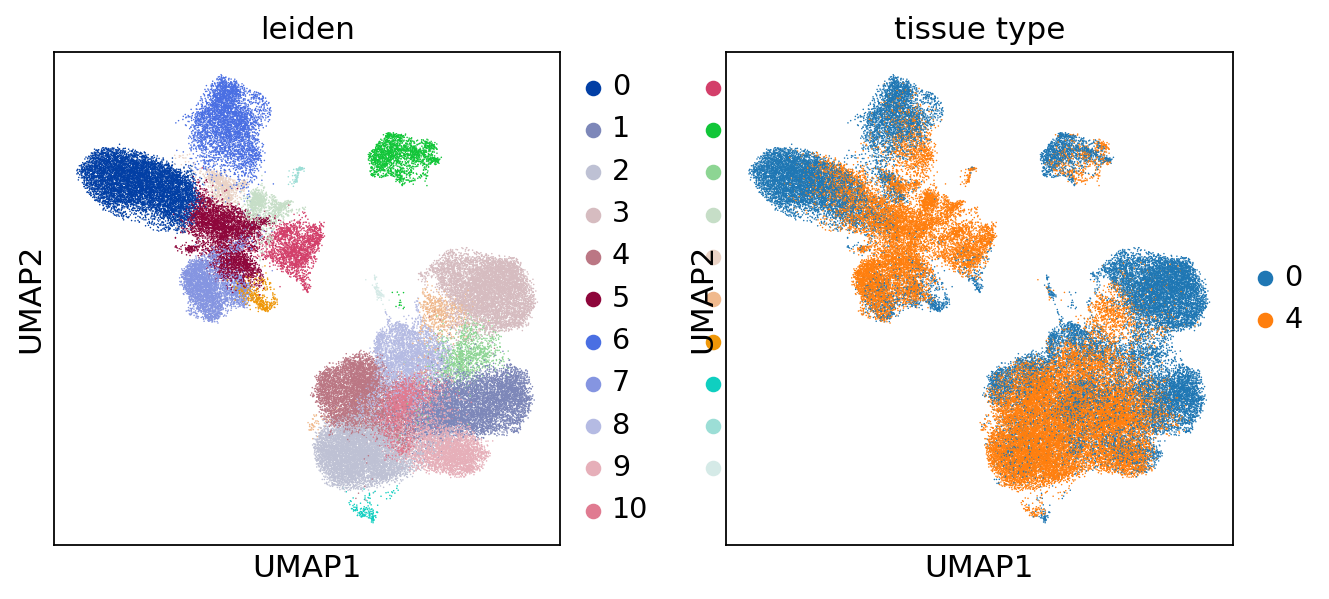

In [35]:
reserve_flag = [each in [0, 4] for each in test_tissue_type] 

adata = sc.AnnData(X=test_set_plip_feats[reserve_flag, :])
# print(pd.Series(set_name, name="set_name"))
# adata.obs['w_coord', 'h_coord'] = pd.DataFrame(set_coords, columns=["w_coord", "h_coord"])
# adata.obs['slides_id'] = pd.DataFrame(slides_id, columns=['slides_id'])
adata.obs = pd.DataFrame(test_tissue_type[reserve_flag].astype(str), columns=["tissue type"])
# adata.obs = pd.DataFrame(slides_id, columns=['slides_id'])
print(adata.obs)


sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep='X')
sc.tl.leiden(adata)

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'tissue type'])

### below is for cluster comparison [1101]

In [79]:
# feats_path_dir = "/home/cyyan/Projects/HER2proj/results/HEROHE_train_2FeatsCCL_20x/h5_files"
feats_path_dir = "/home/cyyan/Projects/HER2proj/results/TCGA_2FeatsCCL/h5_files"

featpath_list = os.listdir(feats_path_dir)

# set_features = np.empty(shape=(0, 2048))
# set_coords = np.empty(shape=(0, 2))
train_set_features = []
train_set_coords = []
train_slides_id = []

num_perslide = 100
flag = "mean"

for name in tqdm(featpath_list):
    full_path = os.path.join(feats_path_dir, name)
    # print(full_path)
        
    # features = torch.load(full_path)
    with h5py.File(full_path,'r') as hdf5_file:
        features = hdf5_file['features'][:]
        coords = hdf5_file['coords'][:]

    if flag == "mean":
        train_set_features.append(np.mean(features, axis=0)[None, ])
        train_set_coords.append(np.mean(coords, axis=0)[None, ])
        train_slides_id.append(name.split('.')[0])

    elif flag == "random":
        idx = np.random.choice(len(features), num_perslide) if num_perslide < len(features) else range(len(features))

        train_set_features.append(features[idx, :])
        train_set_coords.append(coords[idx, :])
        train_slides_id.extend([name.split('.')[0]]*len(idx))

train_set_features = np.concatenate(train_set_features, axis=0)
train_set_coords = np.concatenate(train_set_coords, axis=0)
print("total features, shape: {}".format(train_set_features.shape))
print("total coords, shape: {}".format(train_set_coords.shape))
print("total slide_ids, shape: {}".format(len(train_slides_id)))

  0%|          | 0/1131 [00:00<?, ?it/s]

100%|██████████| 1131/1131 [1:02:37<00:00,  3.32s/it]

total features, shape: (1131, 2048)
total coords, shape: (1131, 2)
total slide_ids, shape: 1131


In [80]:
# feats_path_dir = "/home/cyyan/Projects/HER2proj/results/HEROHE_test_2FeatsCCL_20x/h5_files"
feats_path_dir = "/home/cyyan/Projects/HER2proj/results/TCGA_2FeatsCCL_20x/h5_files"

featpath_list = os.listdir(feats_path_dir)

# set_features = np.empty(shape=(0, 2048))
# set_coords = np.empty(shape=(0, 2))
test_set_features = []
test_set_coords = []
test_slides_id = []

num_perslide = 100
flag = "mean"

for name in tqdm(featpath_list):
    full_path = os.path.join(feats_path_dir, name)
    # print(full_path)
        
    # features = torch.load(full_path)
    with h5py.File(full_path,'r') as hdf5_file:
        features = hdf5_file['features'][:]
        coords = hdf5_file['coords'][:]

    if flag == "mean":
        test_set_features.append(np.mean(features, axis=0)[None, ])
        test_set_coords.append(np.mean(coords, axis=0)[None, ])
        test_slides_id.append(name.split('.')[0])

    elif flag == "random":
        idx = np.random.choice(len(features), num_perslide) if num_perslide < len(features) else range(len(features))

        test_set_features.append(features[idx, :])
        test_set_coords.append(coords[idx, :])
        test_slides_id.extend([name.split('.')[0]]*len(idx))

test_set_features = np.concatenate(test_set_features, axis=0)
test_set_coords = np.concatenate(test_set_coords, axis=0)
print("total features, shape: {}".format(test_set_features.shape))
print("total coords, shape: {}".format(test_set_coords.shape))
print("total slide_ids, shape: {}".format(len(test_slides_id)))

100%|██████████| 1131/1131 [27:15<00:00,  1.45s/it] 

total features, shape: (1131, 2048)
total coords, shape: (1131, 2)
total slide_ids, shape: 1131


In [82]:
set_features = np.concatenate((train_set_features, test_set_features), axis=0)
set_coords = np.concatenate((train_set_coords, test_set_coords), axis=0)
slides_id = train_slides_id+test_slides_id

print(set_features.shape, set_coords.shape)
print(len(slides_id))
set_name = ['40x']*len(train_slides_id) + ['20x']*len(test_slides_id) 
print(set_name)

(2262, 2048) (2262, 2)
2262
['40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x', '40x'

In [1]:
# TODO combine all feats to observe the difference in UMAP 

NameError: name 'set_name' is not defined

In [83]:

# features = torch.from_numpy(features)
adata = sc.AnnData(X=set_features)
# print(pd.Series(set_name, name="set_name"))
# adata.obs['w_coord', 'h_coord'] = pd.DataFrame(set_coords, columns=["w_coord", "h_coord"])
# adata.obs['slides_id'] = pd.DataFrame(slides_id, columns=['slides_id'])
adata.obs = pd.DataFrame(set_name, columns=["set_name"])
# adata.obs = pd.DataFrame(slides_id, columns=['slides_id'])
adata.obs
# anno = pd.read_csv(filename_sample_annotation)
# adata.obs['cell_groups'] = anno['cell_groups']  # categorical annotation of type pandas.Categorical
# adata.obs['time'] = anno['time']                # numerical annotation of type float
# alternatively, you could also set the whole dataframe
# adata.obs = anno

# adata.write(filename)
# adata.write_csvs(filename)
# adata.write_loom(filename)
# adata = sc.read(filename)


set_name
0         40x
1         40x
2         40x
3         40x
4         40x
...       ...
2257      20x
2258      20x
2259      20x
2260      20x
2261      20x

[2262 rows x 1 columns]

In [19]:

# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

# sc.pl.highest_expr_genes(adata, n_top=20, )
sc.pp.calculate_qc_metrics(adata, inplace=True)
# sc.tl.umap(adata, **tool_params)  # embed a neighborhood graph of the data using UMAP
# sc.pl.umap(adata, **plotting_params)

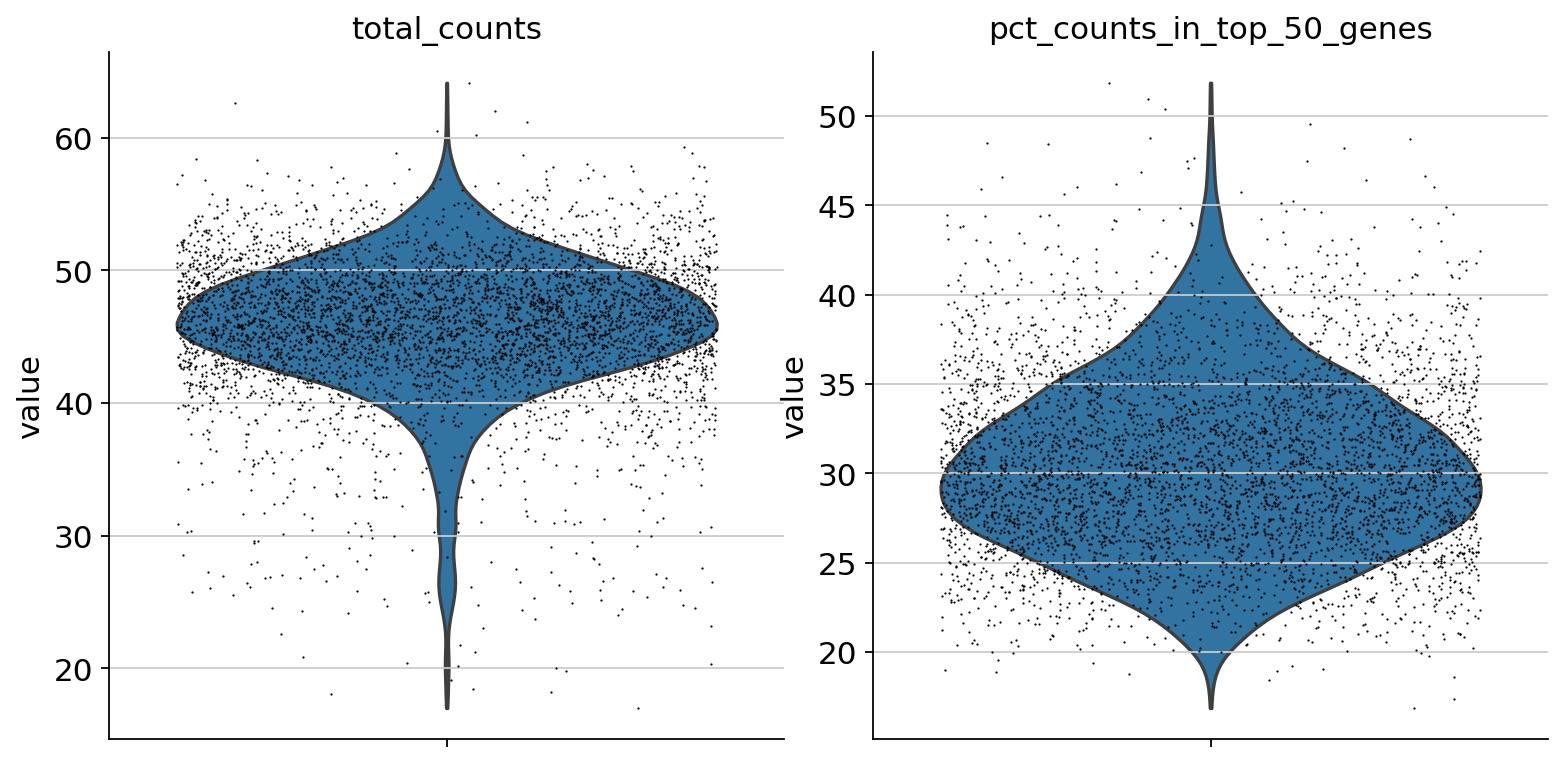

In [26]:
sc.pl.violin(adata, ['total_counts', 'pct_counts_in_top_50_genes'],
             jitter=0.4, multi_panel=True)
# sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


computing PCA
    with n_comps=50
    finished (0:00:00)


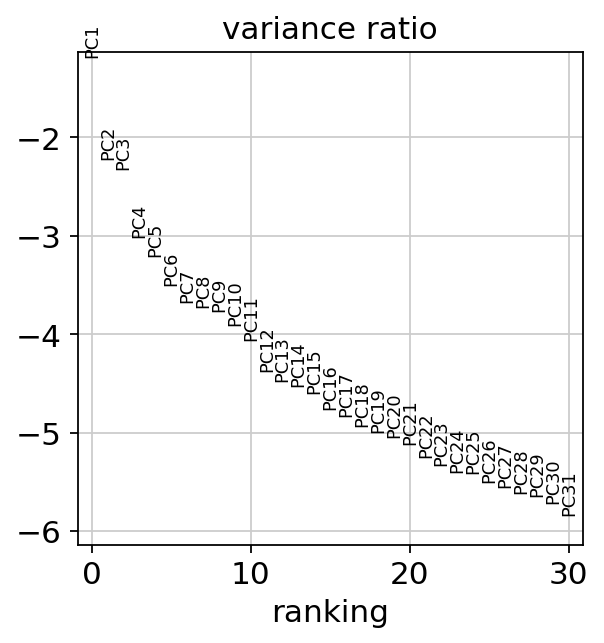

In [32]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


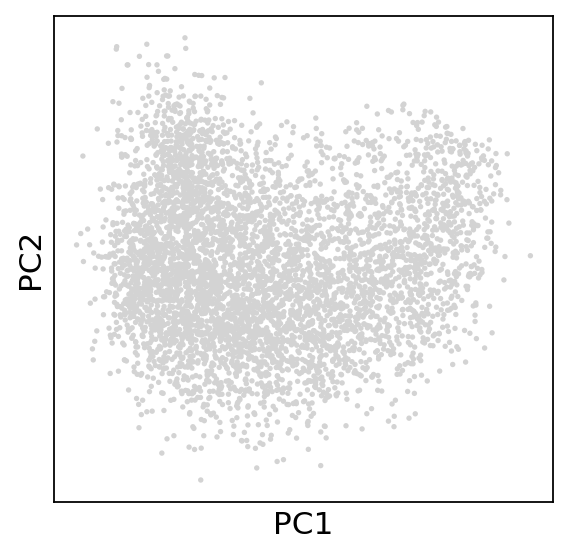

AnnData object with n_obs × n_vars = 5090 × 2048
    obs: 'w_coord', 'h_coord', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [34]:
sc.pl.pca(adata)
adata


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


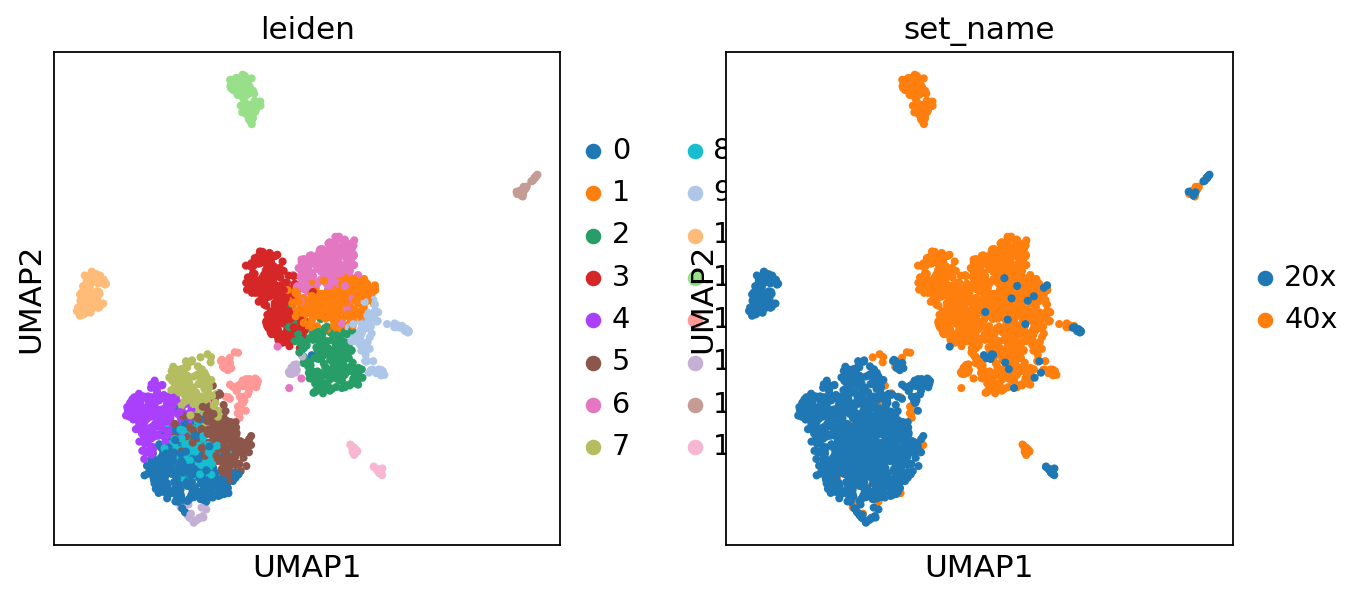

In [84]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep='X')
sc.tl.leiden(adata)

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'set_name'])


computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:20)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


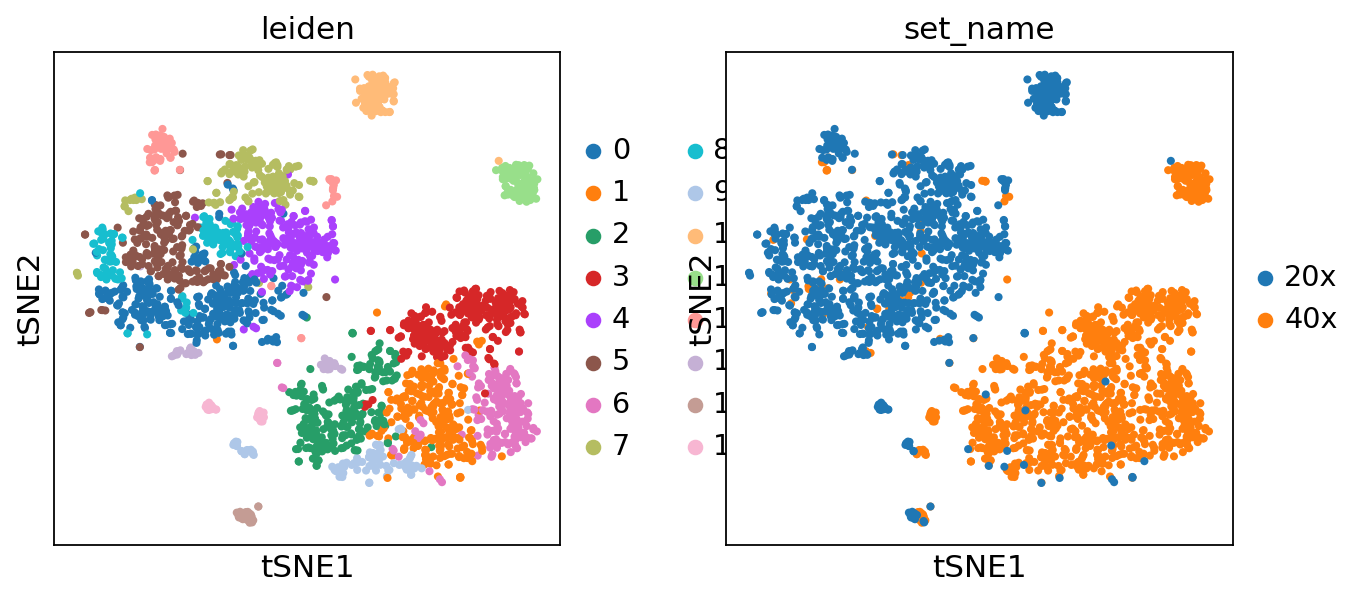

In [85]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['leiden', 'set_name'])

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=40
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


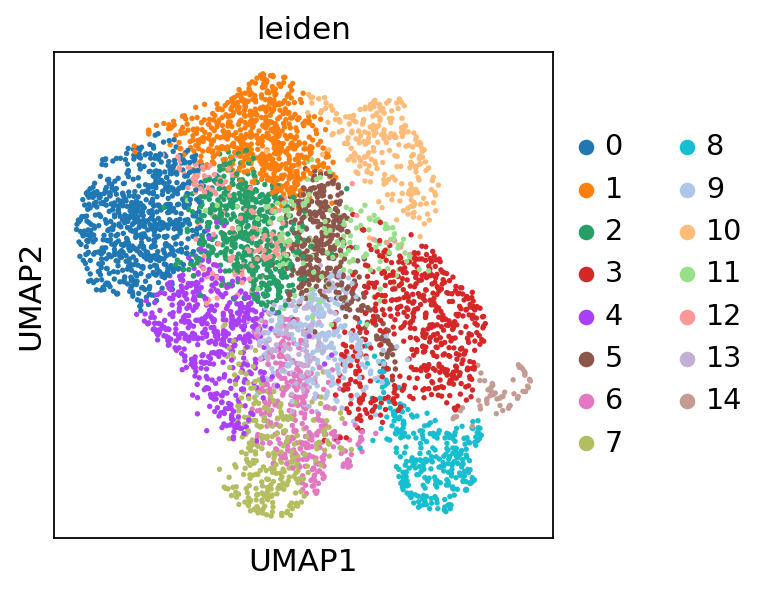

In [100]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden'])

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=40
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


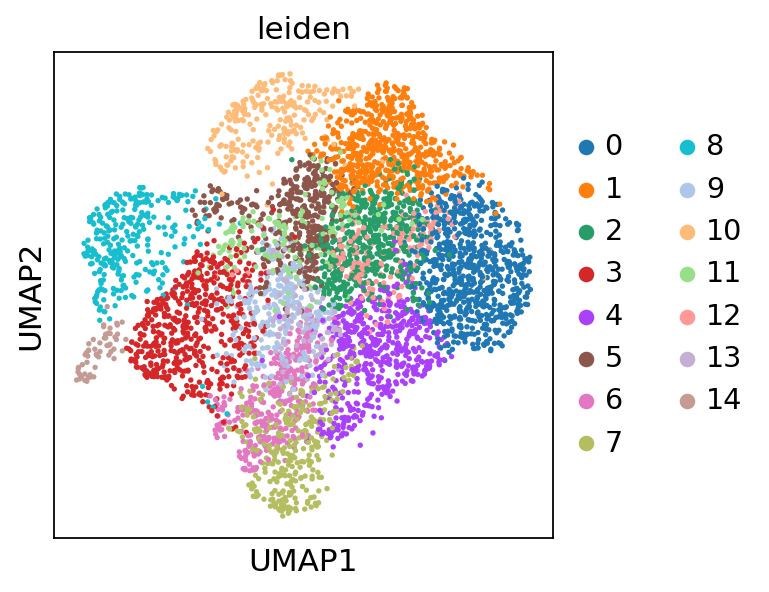

In [91]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'])

In [142]:
adata

AnnData object with n_obs × n_vars = 5090 × 2048
    obs: 'w_coord', 'h_coord', 'leiden'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'leiden_colors', 'dendrogram_leiden'
    obsm: 'X_umap', 'X_pca'
    obsp: 'distances', 'connectivities'

In [154]:
pd.mean(adata).groupby(["leiden"]) # 按照groupby 对cluster进行mean


AttributeError: module 'pandas' has no attribute 'mean'

/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


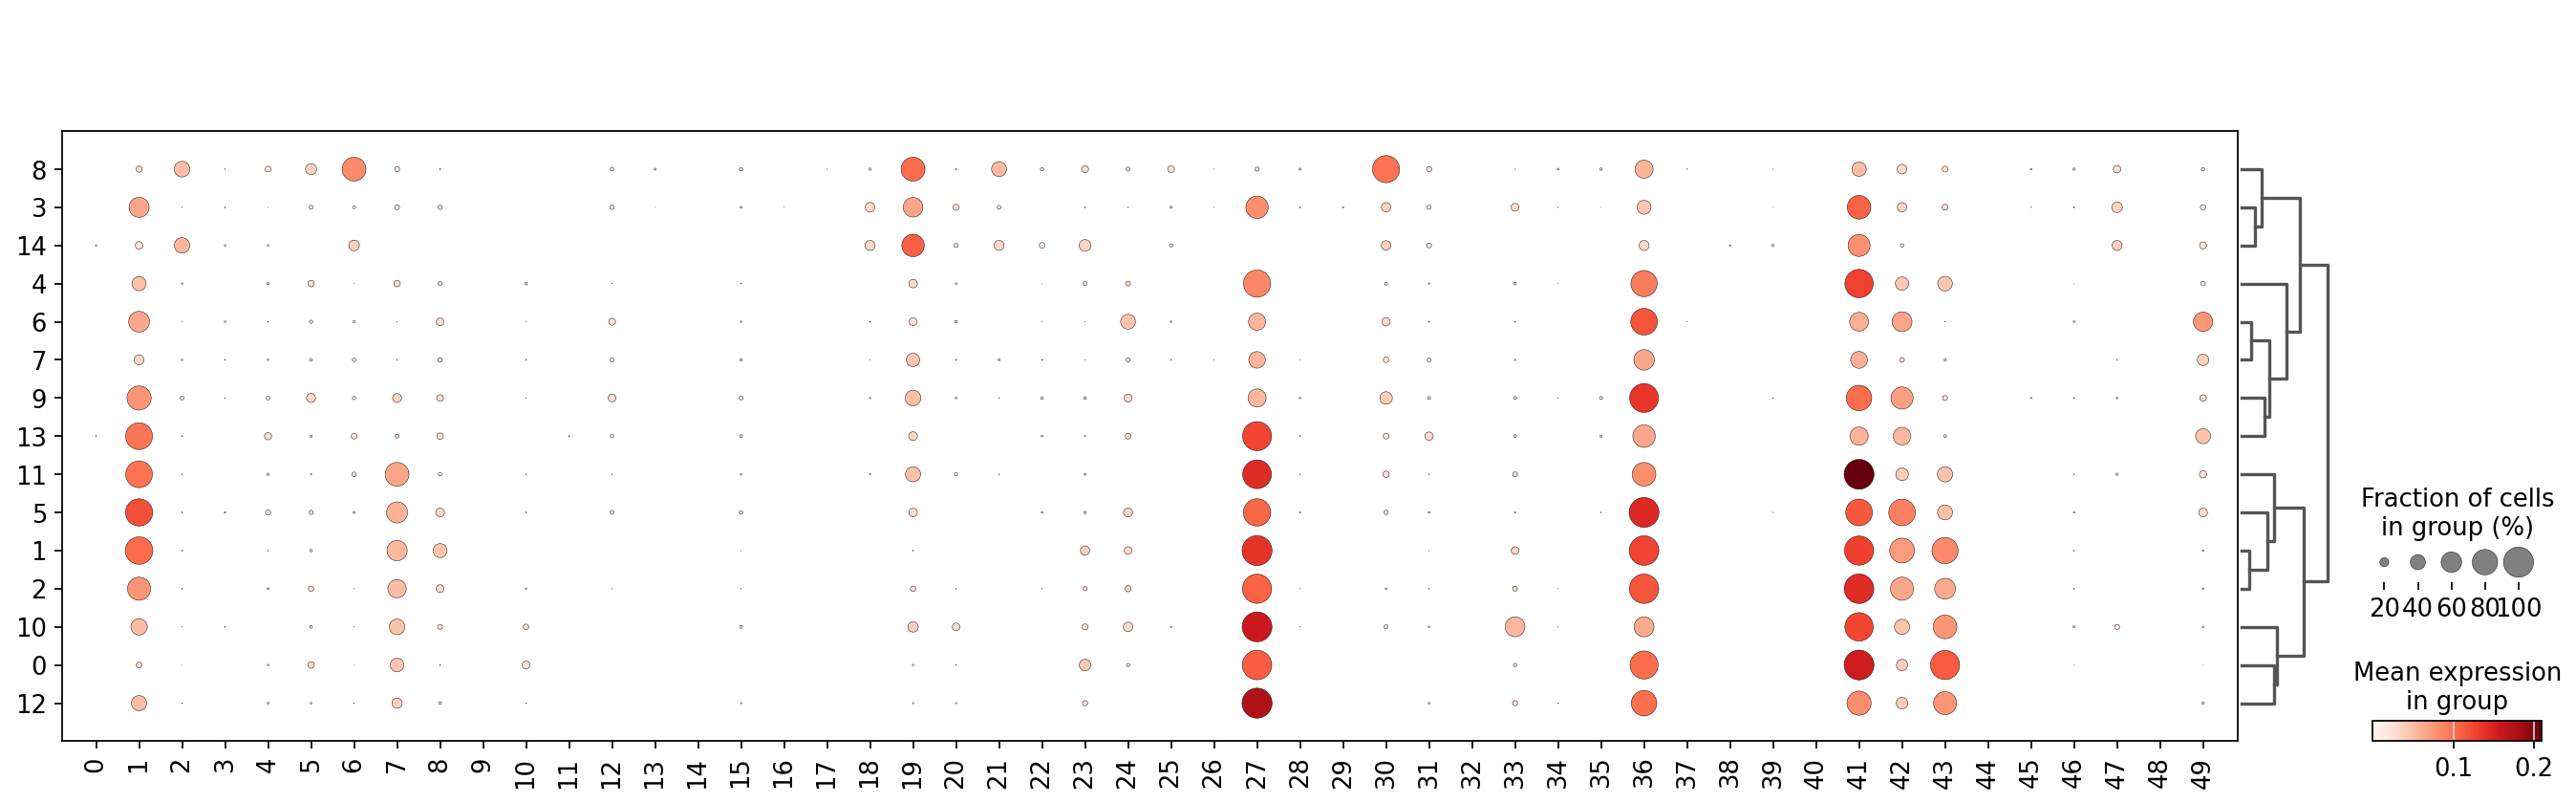

In [130]:
sc.pl.dotplot(adata, adata.var_names[0:50], groupby='leiden', expression_cutoff=0.05, dendrogram=True)

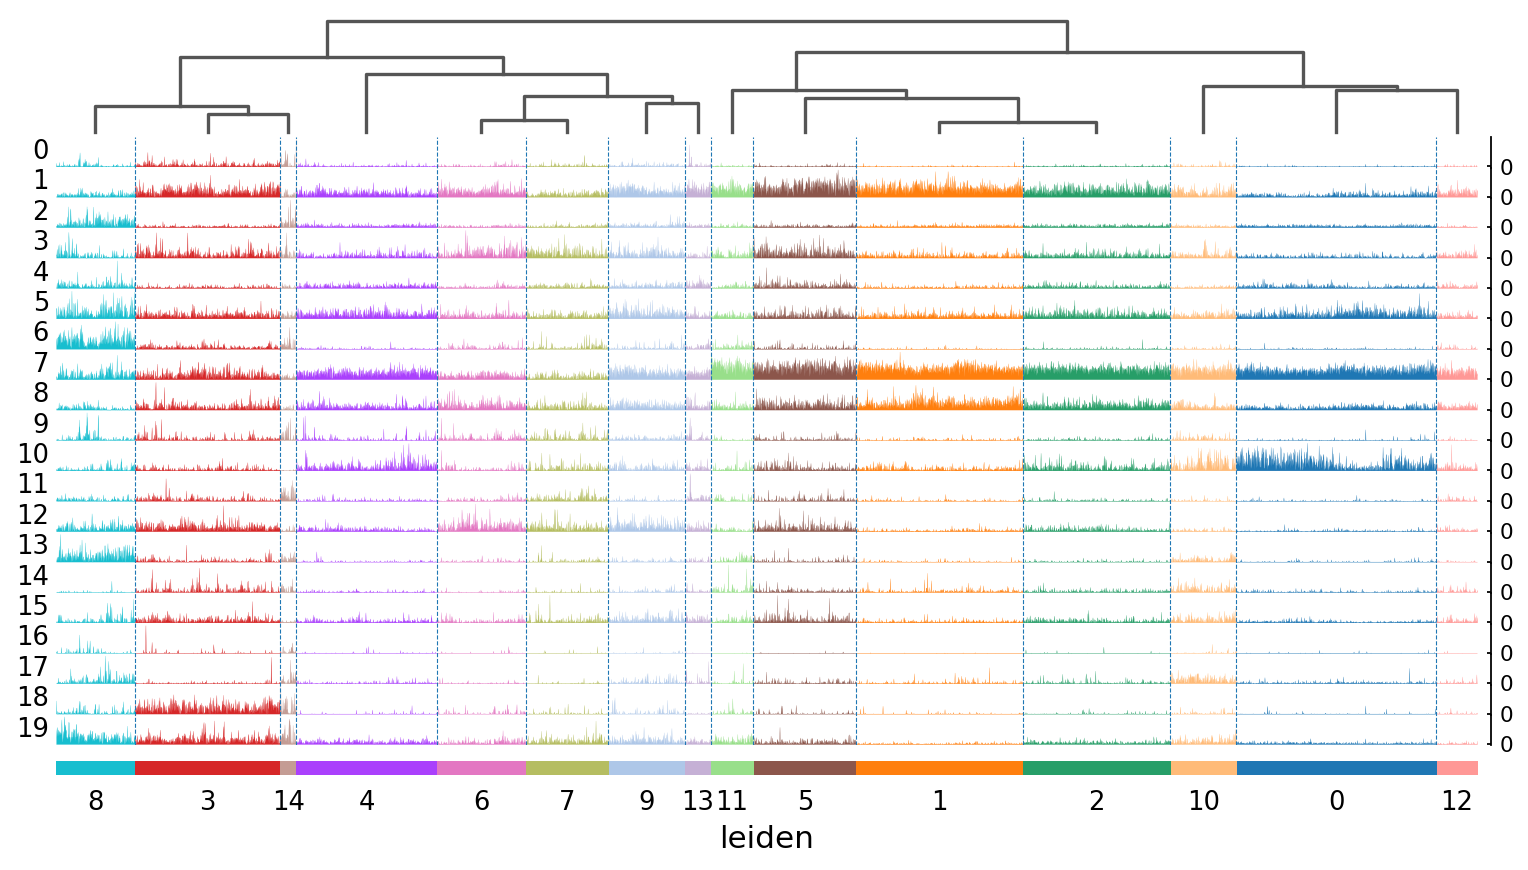

In [133]:
ax = sc.pl.tracksplot(adata, adata.var_names[0:20], groupby='leiden', dendrogram=True)

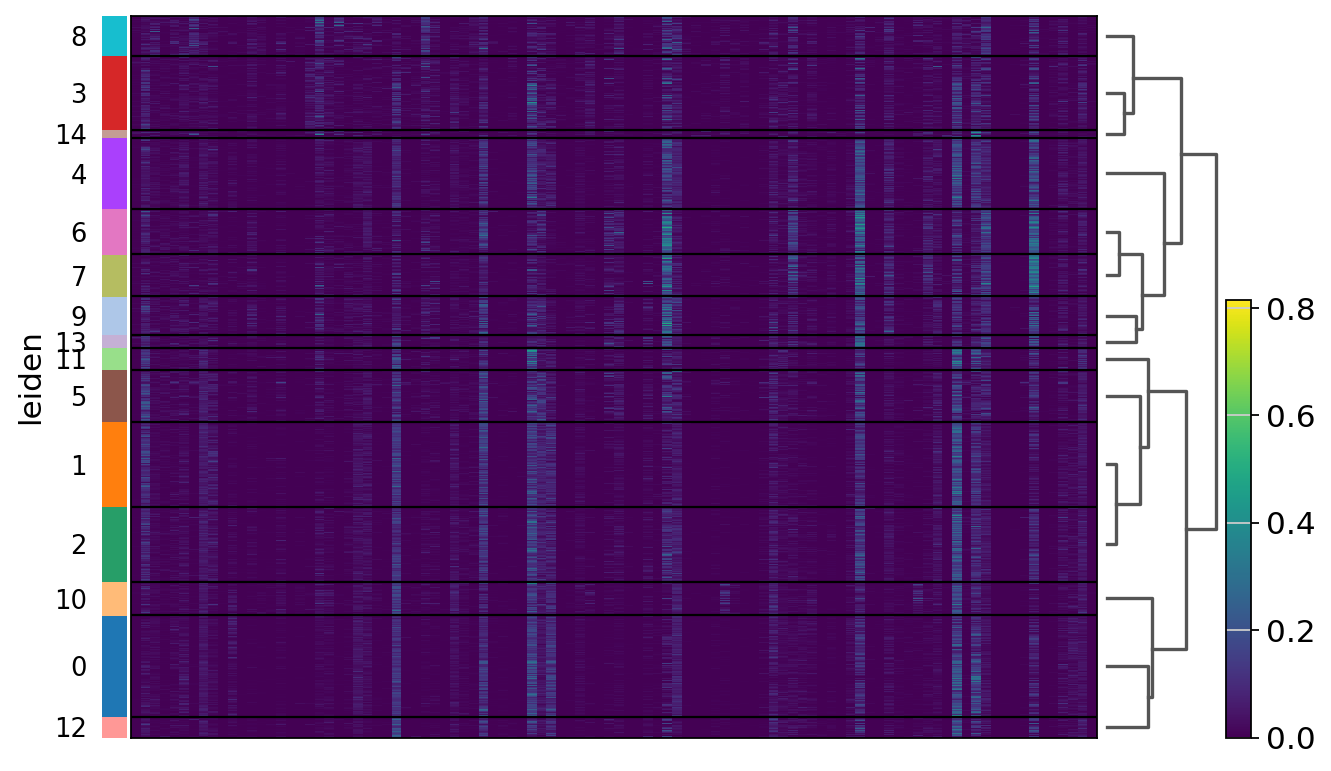

In [141]:
# ax = sc.pl.heatmap(adata, adata.var_names[0:20], groupby='leiden', layer='X', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=True, swap_axes=True, figsize=(11,4))
ax = sc.pl.heatmap(adata, adata.var_names[0:100], groupby='leiden', cmap='viridis', dendrogram=True)
